In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 pip install -U tf_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tf_geometric: filename=tf_geometric-0.1.5-py3-none-any.whl size=104502 sha256=836bcdcaf1ac94245ad6af8a74916013aa275757b3ac2a17668bcb296f5d76a5
  Stored in directory: /root/.cache/pip/wheels/cf/0e/e7/82ab26e3708e81c2e00149154a67ae40ddfe8e59270932537e
  Created wheel for ogb_lite: filename=ogb_lite-0.0.3-py3-none-any.whl size=33523 sha256=4b13808472f3407b0a7c9cfe3309b9f1f55ba238fe3adee90629f606d94d8a8d
  Stored in directory: /root/.cache/pip/wheels/d4/4a/ef/0078cede97d0b5ac3c64be4078dd56020dc1009fc52b10f00e
  Created wheel for tf_sparse: filename=tf_sparse-0.0.17-py3-none-any.whl size=21274 sha256=d458a2e9c0827e356a75ed2024511240a2

In [3]:
import os
from tf_geometric.utils import tf_utils

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# # In case of any corpus are missing 
# download all-nltk
nltk.download('stopwords')
stop_words = stopwords.words("english")

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
import tensorflow as tf
import tf_geometric as tfg
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
train_data= pd.read_excel('/content/review-details.xlsx')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
test_data= pd.read_excel('/content/review-details.xlsx')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
train_data.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,dimension2,dimension3,dimension4,dimension5,dimension6,dimension7,dimension8,verified_purchase,helpful_review_count,review_hash_id
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,Male Anti-Perspirant Deodorant,COTC Male Anti-Perspirant Deodorant,NaN,NaN,NaN,COTC Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,COTC Yeast Extract,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,COTC Yeast Extract,COTC Yeast Extract,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Stock Pots,NaN,NaN,NaN,Stock Pots,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,Bathroom Mousse,Bathroom Mousse,NaN,NaN,NaN,NaN,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae


In [7]:
train_data["verified_purchase"].value_counts(normalize=True)
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True     0.556977
False    0.443023
Name: verified_purchase, dtype: float64

In [8]:
train_data.isna().sum()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


report_date                  0
online_store                 0
upc                          0
retailer_product_code        0
brand                        0
category                     0
sub_category                 0
product_description          0
review_date                  0
review_rating                0
review_title                98
review_text                  0
is_competitor                0
manufacturer                 0
market                       0
matched_keywords          2501
time_of_publication       2501
url                        847
review_type                  0
parent_review                0
manufacturers_response    2501
dimension1                   0
dimension2                   0
dimension3                 191
dimension4                2501
dimension5                2501
dimension6                2501
dimension7                   2
dimension8                   0
verified_purchase            0
helpful_review_count         0
review_hash_id               0
dtype: i

In [9]:
def clean_text(x):
  x = x.lower()
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  return x

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
train_data['review_text'] = train_data['review_text'].apply(clean_text)
test_data['review_text'] = test_data['review_text'].apply(clean_text)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
train_texts= train_data['review_text']
test_texts = test_data['review_text']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
train_labels = train_data['verified_purchase']
test_labels = test_data['verified_purchase']
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
class PMIModel(object):

    def __init__(self):
        self.word_counter = None
        self.pair_counter = None

    def get_pair_id(self, word0, word1):
        pair_id = tuple(sorted([word0, word1]))
        return pair_id

    def fit(self, sequences, window_size):

        self.word_counter = Counter()
        self.pair_counter = Counter()
        num_windows = 0
        for sequence in tqdm(sequences):
            for offset in range(len(sequence) - window_size):
                window = sequence[offset:offset + window_size]
                num_windows += 1
                for i, word0 in enumerate(window):
                    self.word_counter[word0] += 1
                    for j, word1 in enumerate(window[i + 1:]):
                        pair_id = self.get_pair_id(word0, word1)
                        self.pair_counter[pair_id] += 1

        for word, count in self.word_counter.items():
            self.word_counter[word] = count / num_windows
        for pair_id, count in self.pair_counter.items():
            self.pair_counter[pair_id] = count / num_windows

    def transform(self, word0, word1):
        prob_a = self.word_counter[word0]
        prob_b = self.word_counter[word1]
        pair_id = self.get_pair_id(word0, word1)
        prob_pair = self.pair_counter[pair_id]

        if prob_a == 0 or prob_b == 0 or prob_pair == 0:
           return 0

        pmi = np.log(prob_pair / (prob_a * prob_b))
        # print(word0, word1, pmi)
        pmi = np.maximum(pmi, 0.0)
        # print(pmi)
        return pmi

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def build_word_graph(num_words, pmi_model, embedding_size):
    x = tf.Variable(tf.random.truncated_normal([num_words, embedding_size], stddev=1 / np.sqrt(embedding_size)),
                    dtype=tf.float32)
    edges = []
    edge_weight = []
    for (word0, word1) in pmi_model.pair_counter.keys():
        pmi = pmi_model.transform(word0, word1)
        if pmi > 0:
            edges.append([word0, word1])
            edge_weight.append(pmi)
            edges.append([word1, word0])
            edge_weight.append(pmi)
    edge_index = np.array(edges).T
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def build_combined_graph(word_graph, sequences, embedding_size):
    num_words = word_graph.num_nodes
    x = tf.zeros([len(sequences), embedding_size], dtype=tf.float32)
    edges = []
    edge_weight = []
    for i, sequence in enumerate(sequences):
        doc_node_index = num_words + i
        for word in sequence:
            edges.append([doc_node_index, word])  # only directed edge
            edge_weight.append(1.0)  # use BOW instaead of TF-IDF

    edge_index = np.array(edges).T
    x = tf.concat([word_graph.x, x], axis=0)
    edge_index = np.concatenate([word_graph.edge_index, edge_index], axis=1)
    edge_weight = np.concatenate([word_graph.edge_weight, edge_weight], axis=0)
    return tfg.Graph(x=x, edge_index=edge_index, edge_weight=edge_weight)
     


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
pmi_cache_path = "cached_pmi_model.p"
if os.path.exists(pmi_cache_path):
    with open(pmi_cache_path, "rb") as f:
        pmi_model = pickle.load(f)
else:
    pmi_model = PMIModel()
    pmi_model.fit(train_sequences, window_size=6)
    with open(pmi_cache_path, "wb") as f:
        pickle.dump(pmi_model, f)

embedding_size = 150
num_words = len(tokenizer.word_index) + 1
word_graph = build_word_graph(num_words, pmi_model, embedding_size)
train_combined_graph = build_combined_graph(word_graph, train_sequences, embedding_size)
test_combined_graph = build_combined_graph(word_graph, test_sequences, embedding_size)

print(word_graph)
print(train_combined_graph)
print(test_combined_graph)

num_classes =6
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 2501/2501 [00:01<00:00, 2034.45it/s]


Graph Shape: x => (3616, 150)	edge_index => (2, 125168)	y => None
Graph Shape: x => (6117, 150)	edge_index => (2, 165872)	y => None
Graph Shape: x => (6117, 150)	edge_index => (2, 165872)	y => None


In [18]:
class GCNModel(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(100, activation=tf.nn.relu)
        self.gcn1 = tfg.layers.GCN(100, activation=tf.nn.relu)
        self.gcn2 = tfg.layers.GCN(50, activation=tf.nn.relu)
        self.gcn3 = tfg.layers.GCN(num_classes)
        self.dropout = keras.layers.Dropout(0.5)

    def call(self, inputs, training=None, mask=None, cache=None):
        x, edge_index, edge_weight = inputs
        h = self.gcn0([x, edge_index, edge_weight], cache=cache)
        h = self.gcn1([h, edge_index, edge_weight], cache=cache)
        h = self.dropout(h, training=training)
        h = self.gcn2([h, edge_index, edge_weight], cache=cache)
        h = self.gcn3([h, edge_index, edge_weight], cache=cache)
        return h

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
model = GCNModel()
model.gcn0.cache_normed_edge(train_combined_graph)
model.gcn0.cache_normed_edge(test_combined_graph)
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/tf_geometric/layers/conv/gcn.py:126: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead", DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/tf_geometric/layers/conv/gcn.py:126: DeprecationWarning: 'GCN.cache_normed_edge(graph, override)' is deprecated, use 'GCN.build_cache_for_graph(graph, override)' instead
  warnings.warn("'GCN.cache_normed_edge(graph, override)' is deprecated, use

In [20]:
@tf_utils.function
def forward(graph, training=False):
    logits = model([graph.x, graph.edge_index, graph.edge_weight], cache=graph.cache, training=training)
    logits = logits[num_words:]
    return logits

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
def compute_loss(logits, labels):
    losses = tf.nn.softmax_cross_entropy_with_logits(
        logits=logits,
        labels=tf.one_hot(labels, depth=num_classes)
    )
    mean_loss = tf.reduce_mean(losses)
    return mean_loss
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
train_losses, train_accs, test_losses, test_accs= [],[],[],[]
for step in range(5000):
    with tf.GradientTape() as tape:
        logits = forward(train_combined_graph, training=True)
        # print("logits" ,logits[0],"Shape",logits[0].shape)
        mean_loss = compute_loss(logits, train_labels)

    vars = tape.watched_variables()
    grads = tape.gradient(mean_loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    if step % 10 == 0:
        # train accuracytf.one_hot(labels, depth=num_classes)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, train_labels), tf.float32)
        train_accuracy = tf.reduce_mean(corrects)
        train_accs.append(train_accuracy)
        train_losses.append(mean_loss)

        logits = forward(test_combined_graph)
        test_loss = compute_loss(logits, test_labels)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, test_labels), tf.float32)
        accuracy = tf.reduce_mean(corrects)
        test_accs.append(accuracy)
        test_losses.append(test_loss)
        print("step = {}\tloss = {}\ttrain_accuracy = {}\ttest_accuracy = {}".format(step, mean_loss, train_accuracy,accuracy))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


step = 0	loss = 1.792863130569458	train_accuracy = 0.011595361866056919	test_accuracy = 0.5557776689529419
step = 10	loss = 0.7152702808380127	train_accuracy = 0.44262295961380005	test_accuracy = 0.7381047606468201
step = 20	loss = 0.6586770415306091	train_accuracy = 0.5565773844718933	test_accuracy = 0.4782087206840515
step = 30	loss = 0.6191509962081909	train_accuracy = 0.7848860621452332	test_accuracy = 0.7153138518333435
step = 40	loss = 0.5771209597587585	train_accuracy = 0.6549380421638489	test_accuracy = 0.8000799417495728
step = 50	loss = 0.5685921311378479	train_accuracy = 0.7576969265937805	test_accuracy = 0.6601359248161316
step = 60	loss = 0.4988139867782593	train_accuracy = 0.8360655903816223	test_accuracy = 0.8352658748626709
step = 70	loss = 0.4465906620025635	train_accuracy = 0.8140743970870972	test_accuracy = 0.8072770833969116
step = 80	loss = 0.4022059738636017	train_accuracy = 0.8596561551094055	test_accuracy = 0.8520591855049133
step = 90	loss = 0.38233503699302673

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


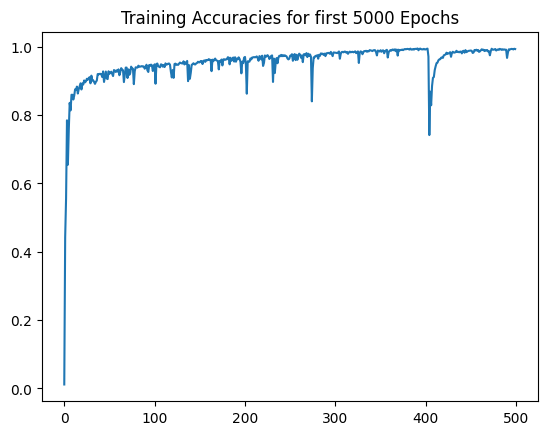

In [24]:
plt.plot(range(len(train_accs)),train_accs)
plt.title("Training Accuracies for first 5000 Epochs")
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


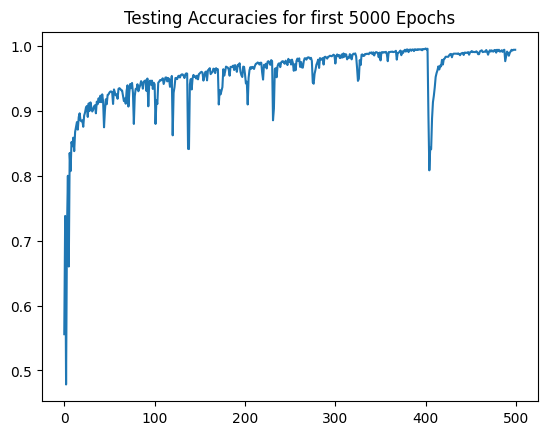

In [25]:
plt.plot(range(len(test_accs)),test_accs)
plt.title("Testing Accuracies for first 5000 Epochs")
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


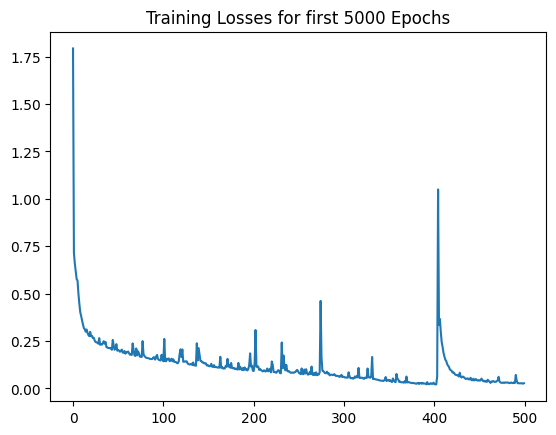

In [26]:
plt.plot(range(len(train_losses)),train_losses)
plt.title("Training Losses for first 5000 Epochs")
plt.show()
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


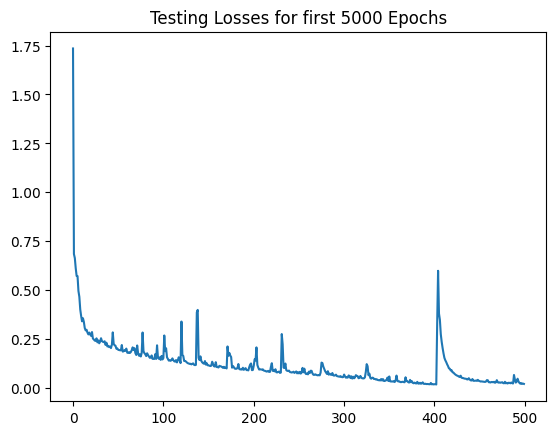

In [27]:
plt.plot(range(len(test_losses)),test_losses)
plt.title("Testing Losses for first 5000 Epochs")
plt.show()
     

In [28]:
train_losses, train_accs, test_losses, test_accs= [],[],[],[]
for step in range(1000):
    with tf.GradientTape() as tape:
        logits = forward(train_combined_graph, training=True)
        # print("logits" ,logits[0],"Shape",logits[0].shape)
        mean_loss = compute_loss(logits, train_labels)

    vars = tape.watched_variables()
    grads = tape.gradient(mean_loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    if step % 10 == 0:
        # train accuracytf.one_hot(labels, depth=num_classes)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, train_labels), tf.float32)
        train_accuracy = tf.reduce_mean(corrects)
        train_accs.append(train_accuracy)
        train_losses.append(mean_loss)

        logits = forward(test_combined_graph)
        test_loss = compute_loss(logits, test_labels)
        preds = tf.argmax(logits, axis=-1)
        corrects = tf.cast(tf.equal(preds, test_labels), tf.float32)
        accuracy = tf.reduce_mean(corrects)
        test_accs.append(accuracy)
        test_losses.append(test_loss)
        print("step = {}\tloss = {}\ttrain_accuracy = {}\ttest_accuracy = {}".format(step, mean_loss, train_accuracy,accuracy))
     

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


step = 0	loss = 0.025460053235292435	train_accuracy = 0.9924030303955078	test_accuracy = 0.9948020577430725
step = 10	loss = 0.030523240566253662	train_accuracy = 0.9920032024383545	test_accuracy = 0.9948020577430725
step = 20	loss = 0.026897896081209183	train_accuracy = 0.9928028583526611	test_accuracy = 0.9956017732620239
step = 30	loss = 0.025532636791467667	train_accuracy = 0.9940024018287659	test_accuracy = 0.9908036589622498
step = 40	loss = 0.023982930928468704	train_accuracy = 0.9932027459144592	test_accuracy = 0.9936025738716125
step = 50	loss = 0.023390674963593483	train_accuracy = 0.9948020577430725	test_accuracy = 0.9944022297859192
step = 60	loss = 0.027207637205719948	train_accuracy = 0.9916033744812012	test_accuracy = 0.9956017732620239
step = 70	loss = 0.02941787987947464	train_accuracy = 0.9908036589622498	test_accuracy = 0.9948020577430725
step = 80	loss = 0.027529772371053696	train_accuracy = 0.9912035465240479	test_accuracy = 0.9952019453048706
step = 90	loss = 0.02

In [29]:
#GCN accuracy:

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
print("Best Training Accuracy - " ,max(np.array(train_accs))*100)

Best Training Accuracy -  99.7201144695282


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
print("Best Testing Accuracy - " ,max(np.array(test_accs))*100)

Best Testing Accuracy -  99.76009726524353


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
model.save('/content/GCN_model')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
model.save_weights("/content/GCN_model_weights.h5")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
with open("/content/gcn_tokenizer.pkl", "wb") as f:
 pickle.dump(tokenizer, f)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
